<a href="https://colab.research.google.com/github/ThienNguyen3001/scikit-clarans/blob/add-docs/examples/clarans_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## scikit-clarans examples

This notebook contains practical examples demonstrating how to use the `scikit-clarans` library (CLARANS). Sections include quickstart, API examples, cookbook recipes, integrations, profiling, and packaging.

Table of contents

1. Installation & Import
2. Quickstart
3. Function examples
4. Classes & objects
5. Cookbook
6. Data handling & pandas
7. Async & Concurrency
8. Testing & Examples as tests
9. Error handling & edge cases
10. Performance & Profiling
11. Extending & Plugins
12. Real-world example (End-to-end)
13. Typing & Static checking
14. Debugging & Logging

> Note: Code cells are intended to run in a standard Python environment (numpy, scikit-learn, matplotlib). Optional dependencies are wrapped in try/except blocks.

## 1. Installation & Import

Below is a basic import check.

In [1]:
# On colab
%%bash

repo_url="https://github.com/ThienNguyen3001/scikit-clarans.git"
repo_name="scikit-clarans"

if [ -d "$repo_name" ]; then
  echo "Repository '$repo_name' already exists. Pulling latest changes..."
  (cd "$repo_name" && git pull)
else
  echo "Cloning repository '$repo_name' from $repo_url..."
  git clone "$repo_url"
fi

Cloning repository 'scikit-clarans' from https://github.com/ThienNguyen3001/scikit-clarans.git...


Cloning into 'scikit-clarans'...


In [7]:
%cd scikit-clarans

/content/scikit-clarans


In [8]:
!pip install .

Processing /content/scikit-clarans
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-clarans: filename=scikit_clarans-0.1.0-py3-none-any.whl size=18349 sha256=fb9fe4f8266bb60d2e4a80e6c83c7e7c426431f146ba0c7db5e2e32f6220d95a
  Stored in directory: /root/.cache/pip/wheels/68/69/67/aa9a2a158af7597a6f70facf8914ba4d5ec715da0d71ed359f
Successfully built scikit-clarans


In [ ]:
# # On your local
# # Basic import test
# import importlib

# try:
#     import clarans
#     from clarans import CLARANS
#     print("clarans imported from:", clarans.__file__)
# except Exception as e:
#     print("Import failed:", e)

# try:
#     import sklearn
#     import numpy as np
#     print("scikit-learn:", sklearn.__version__, "numpy:", np.__version__)
# except Exception as e:
#     print("Dependency check failed:", e)

## 2. Quickstart

A short 'hello world' example to run the library's main functionality:
- Generate 2D sample data
- Fit the model
- Plot the result inline in the notebook

Medoid indices: [314  98 333 163]


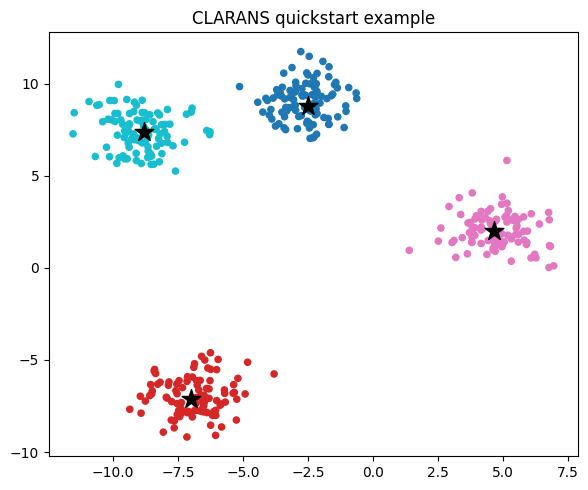

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from clarans import CLARANS
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=400, centers=4, n_features=2, random_state=42)
model = CLARANS(n_clusters=4, numlocal=3, init="k-medoids++", random_state=42)
model.fit(X)

print("Medoid indices:", model.medoid_indices_)

plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=20, cmap="tab10")
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c="black", marker="*", s=200)
plt.title("CLARANS quickstart example")
plt.tight_layout()
plt.show()

## 3. Function examples

Useful helper functions are provided in `clarans.initialization` and `clarans.utils`:
- `initialize_k_medoids_plus_plus`, `initialize_build`, `initialize_heuristic`
- `calculate_cost(X, medoid_indices, metric)`

In [10]:
from clarans.initialization import initialize_k_medoids_plus_plus, initialize_build, initialize_heuristic
from clarans.utils import calculate_cost

# Reuse the X from the quickstart cell
medoids_pp = initialize_k_medoids_plus_plus(X, n_clusters=4, random_state=42)
medoids_build = initialize_build(X, n_clusters=4)
medoids_heur = initialize_heuristic(X, n_clusters=4)

print("k-medoids++ medoids:", medoids_pp)
print("BUILD medoids:", medoids_build)
print("heuristic medoids:", medoids_heur)

print("Cost (k-medoids++):", calculate_cost(X, medoids_pp))


k-medoids++ medoids: [102 319 190 199]
BUILD medoids: [276 267 333 242]
heuristic medoids: [276 260 386 247]
Cost (k-medoids++): 603.858302452664


## 4. Classes & objects

`CLARANS` is a scikit-learn compatible estimator. After fitting it exposes attributes such as `medoid_indices_`, `cluster_centers_`, and `labels_`. You can also call `predict` on new data.

In [11]:
model = CLARANS(n_clusters=4, init="heuristic", random_state=0)
model.fit(X)

print("n_iter_:", getattr(model, "n_iter_", None))
print("medoid_indices_:", model.medoid_indices_)
print("cluster_centers_ shape:", model.cluster_centers_.shape)

# Predict on a couple of new points
new_points = [[0, 0], [3, 3]]
print("Predictions for new points:", model.predict(new_points))


n_iter_: 43
medoid_indices_: [242 254  17  98]
cluster_centers_ shape: (4, 2)
Predictions for new points: [1 1]


## 5. Cookbook: Short recipes

A handful of short, copy/paste-ready examples for common tasks that are convenient to put in README or docs.

In [12]:
# Use sparse input (scipy sparse)
try:
    from scipy import sparse
    Xs = sparse.csr_matrix(X)
    CLARANS(n_clusters=3).fit(Xs)
    print("Sparse input example: OK")
except Exception as e:
    print("Sparse example skipped:", e)

# Use cosine metric
CLARANS(n_clusters=4, metric="cosine").fit(X)
print("Cosine metric example: OK")

# Custom initialization by providing array-like centers
import numpy as np
centers = np.array([[0.0, 0.0], [3.0, 3.0], [1.5, -1.0], [-2.0, 2.0]])
CLARANS(n_clusters=4, init=centers).fit(X)
print("Custom init example: OK")

Sparse input example: OK
Cosine metric example: OK


/content/scikit-clarans/clarans/clarans.py:193: UserWarning: Provided init centers map to duplicate points in X. Filling duplicates with random points.
  warnings.warn(
/content/scikit-clarans/clarans/clarans.py:193: UserWarning: Provided init centers map to duplicate points in X. Filling duplicates with random points.
  warnings.warn(


Custom init example: OK


## 6. Data handling & pandas

Easily use pandas `DataFrame` and convert to NumPy arrays with `.values` or `.to_numpy()`.

In [13]:
import pandas as pd

config = {"n_clusters": 4, "numlocal": 3, "init": "k-medoids++"}
model = CLARANS(**config)
model.fit(X)
print("Config example medoids:", model.medoid_indices_)

# Pandas example
df = pd.DataFrame(X, columns=["x1", "x2"])
model = CLARANS(n_clusters=4).fit(df.values)
print("DataFrame -> .values -> OK")

Config example medoids: [ 98  24 333 234]
DataFrame -> .values -> OK


## 7. Async & Concurrency

Example showing how to run multiple fits in parallel using `concurrent.futures`.

In [14]:
from concurrent.futures import ThreadPoolExecutor

seeds = [0, 1, 2, 3]

def run(seed):
    m = CLARANS(n_clusters=4, random_state=seed).fit(X)
    return seed, calculate_cost(X, m.medoid_indices_)

with ThreadPoolExecutor(max_workers=4) as ex:
    for seed, cost in ex.map(run, seeds):
        print(f"seed={seed} cost={cost:.2f}")

seed=0 cost=492.03
seed=1 cost=494.91
seed=2 cost=493.17
seed=3 cost=496.24


## 8. Testing & Examples as tests

A small pytest-style example that demonstrates testing the core API.

In [15]:
# Minimal pytest-style test example

def test_clarans_basic():
    X_small, _ = make_blobs(n_samples=30, centers=3, n_features=2, random_state=0)
    m = CLARANS(n_clusters=3, random_state=0).fit(X_small)
    assert len(m.medoid_indices_) == 3

print('Pytest-style example: function defined (run with pytest)')

Pytest-style example: function defined (run with pytest)


## 9. Error handling & edge cases

Examples that intentionally raise errors and how to catch/validate exceptions.

In [16]:
# n_clusters >= n_samples should raise ValueError
try:
    small = X[:3]
    CLARANS(n_clusters=3).fit(small)
    print("This should not have succeeded")
except ValueError as e:
    print("Caught expected ValueError:", e)

Caught expected ValueError: n_clusters must be less than n_samples


## 10. Performance & Profiling

Use `%timeit` for quick timing and `cProfile` for detailed profiling.

In [17]:
# Timing a small fit using the magic (works in Jupyter environments)
# Uncomment below line in a real Jupyter environment
# %timeit -n 3 CLARANS(n_clusters=4, numlocal=2, random_state=0).fit(X)

# Simple cProfile example saved to file
import cProfile
pr = cProfile.Profile()
pr.enable()
CLARANS(n_clusters=4, numlocal=2, random_state=0).fit(X)
pr.disable()

import io, pstats
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats(10)
print(s.getvalue())

         1228014 function calls (1221096 primitive calls) in 1.730 seconds

   Ordered by: cumulative time
   List reduced from 290 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      3/2    0.000    0.000    1.797    0.899 /usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
      3/2    0.000    0.000    1.797    0.899 {built-in method builtins.exec}
     1725    0.024    0.000    1.590    0.001 /content/scikit-clarans/clarans/utils.py:5(calculate_cost)
     1726    0.038    0.000    1.537    0.001 /usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:185(wrapper)
     1726    0.015    0.000    1.091    0.001 /usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:716(pairwise_distances_argmin_min)
        1    0.104    0.104    1.055    1.055 /content/scikit-clarans/clarans/clarans.py:104(fit)
     1726    0.018    0.000    0.577    0.000 /usr/local/lib/python

## 11. Extending & Plugins

Example showing how to subclass `CLARANS` to add logging or custom behavior.

In [18]:
class VerboseCLARANS(CLARANS):
    def fit(self, X, y=None):
        print("Starting VerboseCLARANS fit with config:", {"n_clusters": self.n_clusters, "numlocal": self.numlocal})
        return super().fit(X, y)

m = VerboseCLARANS(n_clusters=4, numlocal=2).fit(X)
print('Verbose fit done; medoids:', m.medoid_indices_)

Starting VerboseCLARANS fit with config: {'n_clusters': 4, 'numlocal': 2}
Verbose fit done; medoids: [242 267  24 278]


## 12. Real-world example (End-to-end)

Small pipeline demo: scaling -> clustering -> export labels.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()), ('clarans', CLARANS(n_clusters=4))])
pipe.fit(X)
labels = pipe.named_steps['clarans'].labels_

import pandas as pd
output = pd.DataFrame(labels, columns=['label'])
print(output)

     label
0        0
1        2
2        0
3        1
4        1
..     ...
395      1
396      1
397      3
398      1
399      2

[400 rows x 1 columns]


## 13. Typing & Static checking

Use type annotations to help mypy and linters understand your API.

In [20]:
from typing import List

def choose_medoids(X: List[List[float]], k: int) -> List[int]:
    """A small helper signature to indicate expected types."""
    # Implementation omitted for brevity - real implementations should be typed
    return list(range(k))

print('Typing example: function signature provided')

Typing example: function signature provided


## 14. Debugging & Logging

Configure logging to monitor the algorithm's behavior during development.

In [21]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('clarans_examples')
logger.info('This is an informational message from the examples notebook')

# Wrap a small run and log elapsed time
import time
start = time.time()
CLARANS(n_clusters=3, random_state=0).fit(X[:200])
logger.info('Run finished in %.3f seconds', time.time() - start)

## 15. Compare with KMeans

Compare CLARANS and scikit-learn's KMeans using silhouette score and runtime. Shows side-by-side plots of the cluster assignments.

CLARANS: silhouette=0.6950, time=2.162s
KMeans:  silhouette=0.6966, time=0.006s


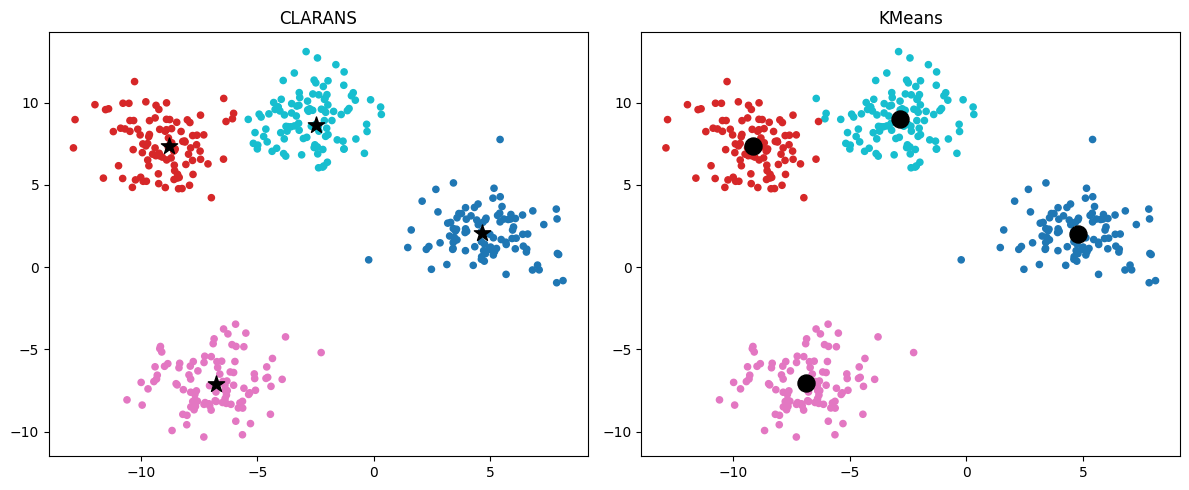

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=400, centers=4, n_features=2, random_state=42, cluster_std=1.5)

# CLARANS
t0 = time.time()
clarans_model = CLARANS(n_clusters=4, random_state=42).fit(X)
clarans_time = time.time() - t0
clarans_sil = silhouette_score(X, clarans_model.labels_)

# KMeans
t0 = time.time()
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
kmeans_time = time.time() - t0
kmeans_sil = silhouette_score(X, kmeans.labels_)

print(f"CLARANS: silhouette={clarans_sil:.4f}, time={clarans_time:.3f}s")
print(f"KMeans:  silhouette={kmeans_sil:.4f}, time={kmeans_time:.3f}s")

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(X[:, 0], X[:, 1], c=clarans_model.labels_, cmap='tab10', s=20)
axes[0].scatter(clarans_model.cluster_centers_[:, 0], clarans_model.cluster_centers_[:, 1], c='k', marker='*', s=150)
axes[0].set_title('CLARANS')

axes[1].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='tab10', s=20)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='k', marker='o', s=150)
axes[1].set_title('KMeans')

plt.tight_layout()
plt.show()